<a href="https://colab.research.google.com/github/ne-mogu-pridumat/matching_product/blob/main/matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Мэтчинг товаров

**Цель и задачи**:
1. Разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
2. Оценить качество алгоритма по метрике accuracy@5.
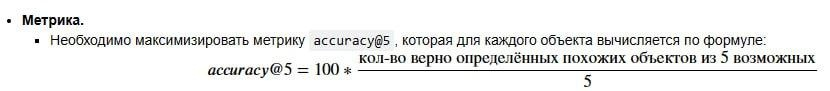

**Данные:**
- base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).
- validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv
- validation_answer.csv - правильные ответы к предыдущему файлу.

**План**:

1. Загрузить датасеты.
2. EDA
3. Подготовка данных к обучению
4. Работа с FAISSA
5. Обучение модели Catboost
6. Вывод


In [ ]:
!pip install faiss-cpu catboost optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox, yeojohnson, normaltest, kstest

#from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
import faiss
import optuna

# Загрузка датасетов

In [ ]:
pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base = pd.read_csv('/content/drive/MyDrive/datasets/base.csv', index_col=0)
train = pd.read_csv('/content/drive/MyDrive/datasets/train.csv', index_col=0)
validation = pd.read_csv('/content/drive/MyDrive/datasets/validation.csv', index_col=0)
validation_answer = pd.read_csv('/content/drive/MyDrive/datasets/validation_answer.csv', index_col=0)

In [ ]:
def convert_float64_to_float32(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].astype('float32')

    return df

In [ ]:
base = convert_float64_to_float32(base)
train = convert_float64_to_float32(train)
validation = convert_float64_to_float32(validation)

# Первичное исследование

In [ ]:
def data_info(data):
    print('Первые 5 строк')
    display(data.head())
    print('Инфо по датасету')
    display(data.info())
    print('Описательная статистика датасета')
    display(data.describe().T)
    print(f'Количество записей {data.shape[0]}')
    print(f'Количество признаков {data.shape[1]}')
    print(f'Количество дубликатов {data.duplicated().sum()}')
    print(f'Количество пропусков {data.isna().sum()}')

In [ ]:
data_info(base)

Первые 5 строк


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,-124.061508,-32.458237,-57.420559,36.207405,182.716766,-28.071688,-5.209374,-1.732183,-91.091858,-79.466667,-103.939087,1507.231323,-32.591667,51.414360,-51.905361,813.770081,-41.556538,8.419807,-129.976639,148.765030,-10.069234,-143.005035,79.848694,-537.183716,2.773180,111.518677,4.257666,-153.340576,-123.626083,-39.707664,-12.768708,-4.170106,-152.967133,75.911522,-57.470089,17.266476,-98.871155,-138.067535,91.000381,-170.701996,-50.020390,59.794296,78.106377,-89.375725,89.412102,79.812180,-129.513611,-44.659496,-80.442207,5.149714,-64.518951,-138.777634,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,-141.304352,-126.768898,-68.853531,8.314717,143.081741,8.778257,15.157185,48.246361,-244.954865,-80.279419,-81.788040,429.880035,-5.937690,70.142654,66.576843,813.770081,3.214371,17.164303,-39.418385,148.155884,-7.579590,-174.369949,101.224632,-303.939240,16.914631,53.394676,33.451824,-148.552628,-110.340172,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948471,62.484821,-166.473358,-189.010422,-56.731556,-30.027319,59.171059,-56.711540,63.542606,-121.319168,97.426056,74.832840,-138.777054,58.887608,-71.595337,-251.952362,11.392853,-148.571655,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,-140.822449,-22.486748,-51.666988,2.521726,140.585449,-22.039230,-7.128633,-5.184787,-111.712120,-79.029266,-82.452576,1507.231323,-0.421011,84.108009,63.344509,813.770081,-105.211052,18.844700,-94.789474,151.387711,-21.483440,-144.845367,48.502934,-780.449158,64.767311,79.781555,-13.390142,-150.061661,-118.758553,-40.896286,-15.222620,-1.860338,-93.820656,98.749069,-46.745781,65.927475,-10.286392,-125.321373,21.048609,-22.637775,68.915985,-54.902260,66.335472,-142.927917,83.030983,69.979630,-123.733887,65.320877,-114.037178,-529.396973,-101.581375,-134.658218,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,-108.470444,-104.537781,-82.388489,-79.986740,113.596313,-38.995880,-4.787360,8.327808,-124.855759,-79.109016,-107.943275,1479.170532,-125.271614,24.656485,-16.921055,813.770081,-182.680267,14.715704,-62.932701,151.201981,10.613454,-134.934341,58.777729,-529.295044,43.665924,92.806305,-38.936657,-145.045303,-124.295769,-36.876732,-17.742870,10.536242,-124.584152,121.914146,-17.321358,105.217239,-94.379646,-63.769272,29.217487,-26.423973,5.869829,64.061546,63.513279,-112.258102,80.926590,72.636101,-137.314316,7.912551,-62.188919,-540.321045,-89.588715,-149.326691,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,-110.342453,-38.982059,-50.228867,-26.690920,135.272903,-7.510103,8.924209,111.576950,-130.833191,-79.315849,-57.843952,1262.919678,19.225910,59.811813,76.159668,312.698914,-76.726974,21.299923,-24.069107,167.385529,-44.059471,-148.131851,98.042610,-657.524414,96.363167,71.061523,-36.563557,-135.372437,-123.708977,-44.739437,-10.855220,8.354800,-168.328857,215.928070,-32.975979,66.864883,30.838631,-211.540375,57.695343,-67.822632,-29.38913

Инфо по датасету
<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 27  27      float32
 28  28      float32
 29  29      float32
 30  30      float32
 31  31      float32
 32  32      float32
 33  33      float32
 34  34      float32
 35  35      float32
 36  36      float32
 37  37      float32
 38  38      float32
 39 

None

Описательная статистика датасета


,count,mean,std,min,25%,50%,75%,max
0,2918139.0,-86.229462,24.891319,-199.468704,-103.065437,-86.231499,-69.256577,21.515549
1,2918139.0,8.080074,4.953387,-13.914608,4.708491,8.038950,11.470066,29.937210
2,2918139.0,-44.580791,38.631660,-240.073395,-69.559486,-43.816605,-19.625266,160.937225
3,2918139.0,-146.635010,19.844805,-232.667145,-159.905060,-146.776810,-133.327652,-51.374779
4,2918139.0,111.316582,46.348091,-105.582962,80.507946,111.873001,142.374275,319.664490
...,...,...,...,...,...,...,...,...
67,2918139.0,23.544888,55.342236,-233.138168,-12.516241,23.416494,59.755114,314.898773
68,2918139.0,74.959343,61.345005,-203.601624,33.775736,74.929970,115.876041,339.573853
69,2918139.0,115.566696,21.175184,15.724480,101.686668,116.024445,129.552376,214.706345
70,2918139.0,-799.339294,385.413055,-1297.931519,-1074.464844,-1074.464844,-505.744446,98.770813


Количество записей 2918139
Количество признаков 72
Количество дубликатов 0
Количество пропусков 0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64


In [ ]:
data_info(train)

Первые 5 строк


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,-88.082687,-52.695541,-27.692442,4.872923,198.348007,-30.075249,-3.803569,-135.810608,-161.841370,-78.512177,-94.428940,898.436951,-70.140518,78.420357,108.032776,813.770081,-74.790878,12.610422,-183.821838,149.715836,-27.042316,-133.212173,106.420746,-303.939240,48.730789,58.185707,24.250950,-151.224106,-104.282265,-34.492809,-12.587054,2.622891,-120.969917,149.991638,-31.948471,82.314430,-115.830467,-243.309387,6.622036,-132.197662,68.712563,-38.806824,62.937435,-132.654449,89.189026,87.039780,-121.279877,-6.986934,-206.513824,29.485588,-77.029587,-132.386169,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,-177.605804,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267029,-78.659431,-92.761490,353.157745,-34.744545,82.487106,-28.450592,813.770081,-137.529633,26.595627,-136.783447,153.357910,48.810093,-115.922150,87.464218,-222.286362,25.124149,91.887138,-30.636869,-136.593140,-140.500122,-43.449757,-7.226884,8.265747,-117.915466,149.150894,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061081,-7.139753,75.862396,-112.045113,82.857727,54.067215,-134.005386,-26.142574,-214.632111,-457.848450,21.459618,-137.411362,-40.812233,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,-86.346558,-35.666546,16.395317,-80.802849,137.908646,-23.532761,-47.256584,-16.650242,-194.505676,-78.372925,-69.324478,1507.231323,-52.500969,-34.165775,52.958652,813.770081,-18.021725,20.951107,-50.321781,158.760620,0.178065,-183.069672,99.053574,-1018.469543,-51.801121,97.766769,-10.865850,-144.423157,-133.819489,-78.902298,-17.200352,4.467452,-63.970737,154.639526,-30.211615,48.527401,-122.406639,-112.713623,53.461838,-31.117260,107.841507,16.482935,77.934479,-95.618729,91.460075,63.119511,-126.939247,8.066628,-195.677673,-163.119995,-72.830002,-139.223068,-52.031662,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255409,-775.150146,79.186523,124.003098,242.650650,-146.517075,-159.469849,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.906830,-78.789322,-78.737091,1507.231323,19.957405,34.834290,-8.820732,813.770081,-125.606796,17.584084,-58.452904,141.281799,-54.959309,-136.988541,63.880493,-1018.469543,89.228928,65.919960,-24.078644,-152.334106,-91.199379,-28.225389,-4.767386,0.158236,-129.128662,122.958366,-30.800995,123.623398,-37.540867,-72.139801,71.240990,-168.115585,118.236450,-18.065195,37.255718,-137.691040,87.500771,62.437290,-131.260635,35.692661,-86.038834,-379.339081,-153.465775,-131.198288,-61.567047,44.515266,-145.416748,93.990982,64.131348,106.061920,83.178757,118.277725,-1074.464844,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052536,57.127068,-16.239529,-321.317963,45.984676,125.941284,103.392670,-107.153023,-8.800034,-50.977798,29.457338,143.389313,5.614824,-45.274761,9.643625,-77.554626,-79.066612,-77.926460,1507.231323,16.612400,116.284286,33.754898,813.770081,-105.765335,6.523008,-19.812988,157.693924,-20.604088,-146.591278,78.849571,-780.449158,87.560768,73.036659,16.891029,-144.657898,-116.122147,-19.353254,-7.709266,-5.394988,-140.252121,193.184967,-53.

Инфо по датасету
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  

None

Описательная статистика датасета


,count,mean,std,min,25%,50%,75%,max
0,100000.0,-85.328667,25.803846,-186.280273,-103.309149,-85.273697,-67.330811,14.585236
1,100000.0,7.664345,4.955651,-11.560507,4.313784,7.652854,10.981191,28.917845
2,100000.0,-43.667046,39.111065,-224.896057,-69.494486,-42.830246,-17.713690,128.108459
3,100000.0,-146.118637,20.434841,-223.307220,-160.028522,-146.067444,-132.277744,-60.751625
4,100000.0,111.770592,47.700958,-93.272018,79.474319,112.260101,143.760826,301.363586
...,...,...,...,...,...,...,...,...
67,100000.0,23.029278,55.470760,-203.746384,-14.144571,23.441362,59.941065,266.493317
68,100000.0,73.412071,62.203133,-181.973816,31.685547,72.880192,114.469225,319.867523
69,100000.0,115.189728,21.582237,22.598862,100.589325,115.236633,129.791080,201.761261
70,100000.0,-709.761536,405.961060,-1297.871948,-1074.464844,-808.801697,-357.087334,98.768234


Количество записей 100000
Количество признаков 73
Количество дубликатов 0
Количество пропусков 0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64


In [ ]:
data_info(validation)

Первые 5 строк


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,-131.892807,-140.968567,-57.987164,-22.868887,150.895523,7.965574,17.622066,-34.868217,-216.138550,-80.908730,-52.579521,263.363129,56.266876,66.924713,21.609911,813.770081,-32.782940,20.794031,-79.779076,156.307083,-42.831329,-71.723335,83.283661,-304.174377,1.609402,55.834587,-29.474255,-139.162766,-126.038353,-62.643829,-5.012346,11.984921,-43.084946,190.123993,-24.996635,76.153900,-245.261566,-143.656479,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697319,60.475632,-127.486870,-39.484753,-124.384575,-307.949768,45.506813,-144.190948,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,-153.717255,-63.951328,-52.369495,-33.390945,148.619507,-22.483829,15.164185,-56.202000,-153.614380,-79.831825,-101.055481,1203.537109,81.597130,101.018654,56.783424,92.209625,-126.860336,10.382887,-38.523361,165.383911,-77.840485,-169.538681,103.483238,-915.735718,16.109938,14.669937,-38.707085,-149.538376,-138.792923,-36.076176,-2.781422,2.283144,-142.477890,189.953949,-18.408230,90.517052,-95.530998,-259.636047,52.437836,-30.004599,14.502060,-1.071201,66.842667,-161.279892,94.794174,50.419983,-125.075256,-25.169033,-176.176880,-655.836914,-99.238373,-141.535217,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319
100002-query,-64.175095,-3.980927,-7.679249,-170.160934,96.446159,-62.377739,-759.626038,87.477554,131.270111,168.920319,-220.309540,-31.378445,-8.788761,2.285323,133.266113,-41.309078,14.305538,-18.231812,-205.533707,-78.160309,-96.607674,1507.231323,-5.964200,34.937443,-56.086887,813.770081,-13.200474,18.966661,-35.110191,151.368500,-17.490252,-145.884293,15.533379,-655.395508,39.412827,62.554955,9.924992,-143.934616,-123.107796,-37.032475,-13.501337,12.913328,-116.038017,176.276154,-45.909943,103.491364,-90.656990,-162.615707,117.128235,13.079479,69.826889,-6.874451,63.707214,-123.851067,91.610817,59.760067,-129.566177,-12.822194,-154.197647,-407.199066,5.522629,-126.812973,-134.795410,37.368729,-159.662308,-119.232727,67.710442,86.002060,137.636414,141.081635,-294.052277,-70.969604
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,58.576405,-19.046659,115.042404,75.206734,-114.271957,-71.406456,-65.349319,24.377069,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690697,-139.227448,325.547119,3.632292,74.929504,-4.802103,813.770081,-52.982597,15.644382,-54.087467,151.309143,21.088570,-134.507889,65.118958,-529.295044,131.565521,67.642700,-22.884491,-145.906525,-86.917328,-11.863579,-22.188885,0.463720,-212.533752,170.522583,-48.092533,99.712555,-194.692413,-141.523178,60.217049,73.386383,118.567856,58.900810,55.569031,-181.091660,83.340485,66.083237,-114.048866,-57.156872,-56.335075,-318.680054,-15.984783,-128.101334,-77.236107,44.100494,-132.530121,-106.318985,70.883957,23.577892,133.183960,143.252945,-799.363647,-89.392670
100004-query,-79.532921,-0.364173,-16.027431,-170.884949,165.453918,-28.291668,33.931934,34.411217,128.903976,102.086914,-76.214172,-26.393860,34.423641,50.938889,157.683182,-23.786497,-33.175415,-0.592607,-193.318542,-79.651031,-91.889786,1358.481079,44.027733,121.527206,46.182999,433.623108,-82.233200,21.068508,-32.940117,149.268951,0.404718,-97.674530,81.719994,-825.644775,9.397169,49.359341,17.725466,-160.168152,-129.367950,-55.532898,-2.597821,-0.226103,-41.369141,92.090195,-58.626858,73.655441,-10.257370,-175.656784,

Инфо по датасету
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-

None

Описательная статистика датасета


,count,mean,std,min,25%,50%,75%,max
0,100000.0,-85.302231,25.777321,-190.353333,-103.231791,-85.296745,-67.422104,14.427986
1,100000.0,7.669724,4.956990,-11.109877,4.292425,7.657888,10.993900,27.409784
2,100000.0,-43.842476,39.138775,-217.538422,-69.680916,-43.230835,-17.765821,134.859802
3,100000.0,-146.119812,20.495541,-220.050888,-160.210285,-146.080368,-132.119274,-57.381889
4,100000.0,111.635078,47.751575,-81.198990,79.101917,111.959332,143.903732,302.065369
...,...,...,...,...,...,...,...,...
67,100000.0,23.250780,55.403862,-210.672806,-13.863008,23.508739,60.154776,251.288589
68,100000.0,73.114449,62.056225,-175.921783,31.494841,72.152397,114.317055,305.937531
69,100000.0,115.196938,21.493080,25.271042,100.538860,115.280991,129.770218,201.599976
70,100000.0,-709.457031,405.665741,-1297.923950,-1074.464844,-807.029694,-358.400482,98.737076


Количество записей 100000
Количество признаков 72
Количество дубликатов 0
Количество пропусков 0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64


In [ ]:
data_info(validation_answer)

Первые 5 строк


,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


Инфо по датасету
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


None

Описательная статистика датасета


,count,unique,top,freq
Expected,100000,91502,210304-base,7


Количество записей 100000
Количество признаков 1
Количество дубликатов 8498
Количество пропусков Expected    0
dtype: int64


**Вывод**

На данном этапе загрузила датасеты. Данные достаточно объемные (более 2 Гб). Пропуски в данных отсутствуют. Датасет `base` содержит 2918139 записей и 72 признака, `train` 100000 записей и 73 признака, `validation` - 100000 записей и 72 признака, `validation_answer` - 100000 записей и 2 признака. На этапе EDA, стоит более детально ознакомится с признакми, так как сложно сказать о рспределениях признаков, изходя из описательной статистике.

# EDA

In [ ]:
class DataVisualizer:
    def __init__(self, pandas_df, sample_size=None):
        self.pandas_df = pandas_df
        self.quantitative_columns = pandas_df.select_dtypes(include=['number']).columns
        self.sample_size = sample_size  # Размер сэмпла

    def plot_quantitative(self):
        num_columns = len(self.quantitative_columns)
        cols = 7  # 7 графиков в ряду
        rows = (num_columns + cols - 1) // cols
        fig, axs = plt.subplots(rows * 2, cols, figsize=(3 * cols, 5 * rows), gridspec_kw={'height_ratios': [0.5, 1.5] * rows})

        for i, column in enumerate(self.quantitative_columns):
            row = i // cols
            col = i % cols

            data = self.pandas_df[column].dropna()

            # Применение сэмплирования
            if self.sample_size and len(data) > self.sample_size:
                data = data.sample(self.sample_size)

            stat, p_value = kstest(data, 'norm')
            norm_test_result = f'p-value Критерий КС: {p_value:.3f}'

            # Построение boxplot
            axs[row * 2, col].boxplot(data, vert=False)
            axs[row * 2, col].set_yticks([])
            axs[row * 2, col].set_xticks([])
            axs[row * 2, col].set_title(f'Ящик с усами {column}')
            axs[row * 2, col].text(0.5, -0.1, norm_test_result, ha='center', va='center', transform=axs[row * 2, col].transAxes, fontsize=10)

            # Построение гистограммы
            sns.histplot(data, ax=axs[row * 2 + 1, col], bins=15, kde=False, stat='density', common_norm=False)
            axs[row * 2 + 1, col].set_title(f'Гистограмма {column}')
            axs[row * 2 + 1, col].set_ylabel('Плотность')
            axs[row * 2, col].set_xticks([])

        for j in range(num_columns, rows * cols):
            fig.delaxes(axs[(j // cols) * 2, j % cols])
            fig.delaxes(axs[(j // cols) * 2 + 1, j % cols])

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.subplots_adjust(top=0.93)
        plt.show()

    def approximate_column(self, column):
        col_data = self.pandas_df[column].dropna()
        statistic, p_value = normaltest(col_data)

        if p_value < 0.05:  # Если данные не распределены нормально
            if np.all(col_data > 0):
                # Попробуем преобразование Бокса-Кокса
                col_data, fitted_lambda = boxcox(col_data)
            else:
                # Попробуем преобразование Йо-Джонсона
                col_data, fitted_lambda = yeojohnson(col_data)

            # Создание новой серии с преобразованными данными
            self.pandas_df[column] = pd.Series(col_data, index=self.pandas_df[column].dropna().index)

    def approximate_quantitative(self):
        for column in self.quantitative_columns:
            self.approximate_column(column)

    def plot_correlation_heatmap(self):
        sampled_df = self.pandas_df[self.quantitative_columns]

        # Применение сэмплирования
        if self.sample_size and len(sampled_df) > self.sample_size:
            sampled_df = sampled_df.sample(self.sample_size)

        correlation_matrix = sampled_df.corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
        plt.title('Тепловая карта')
        plt.show()

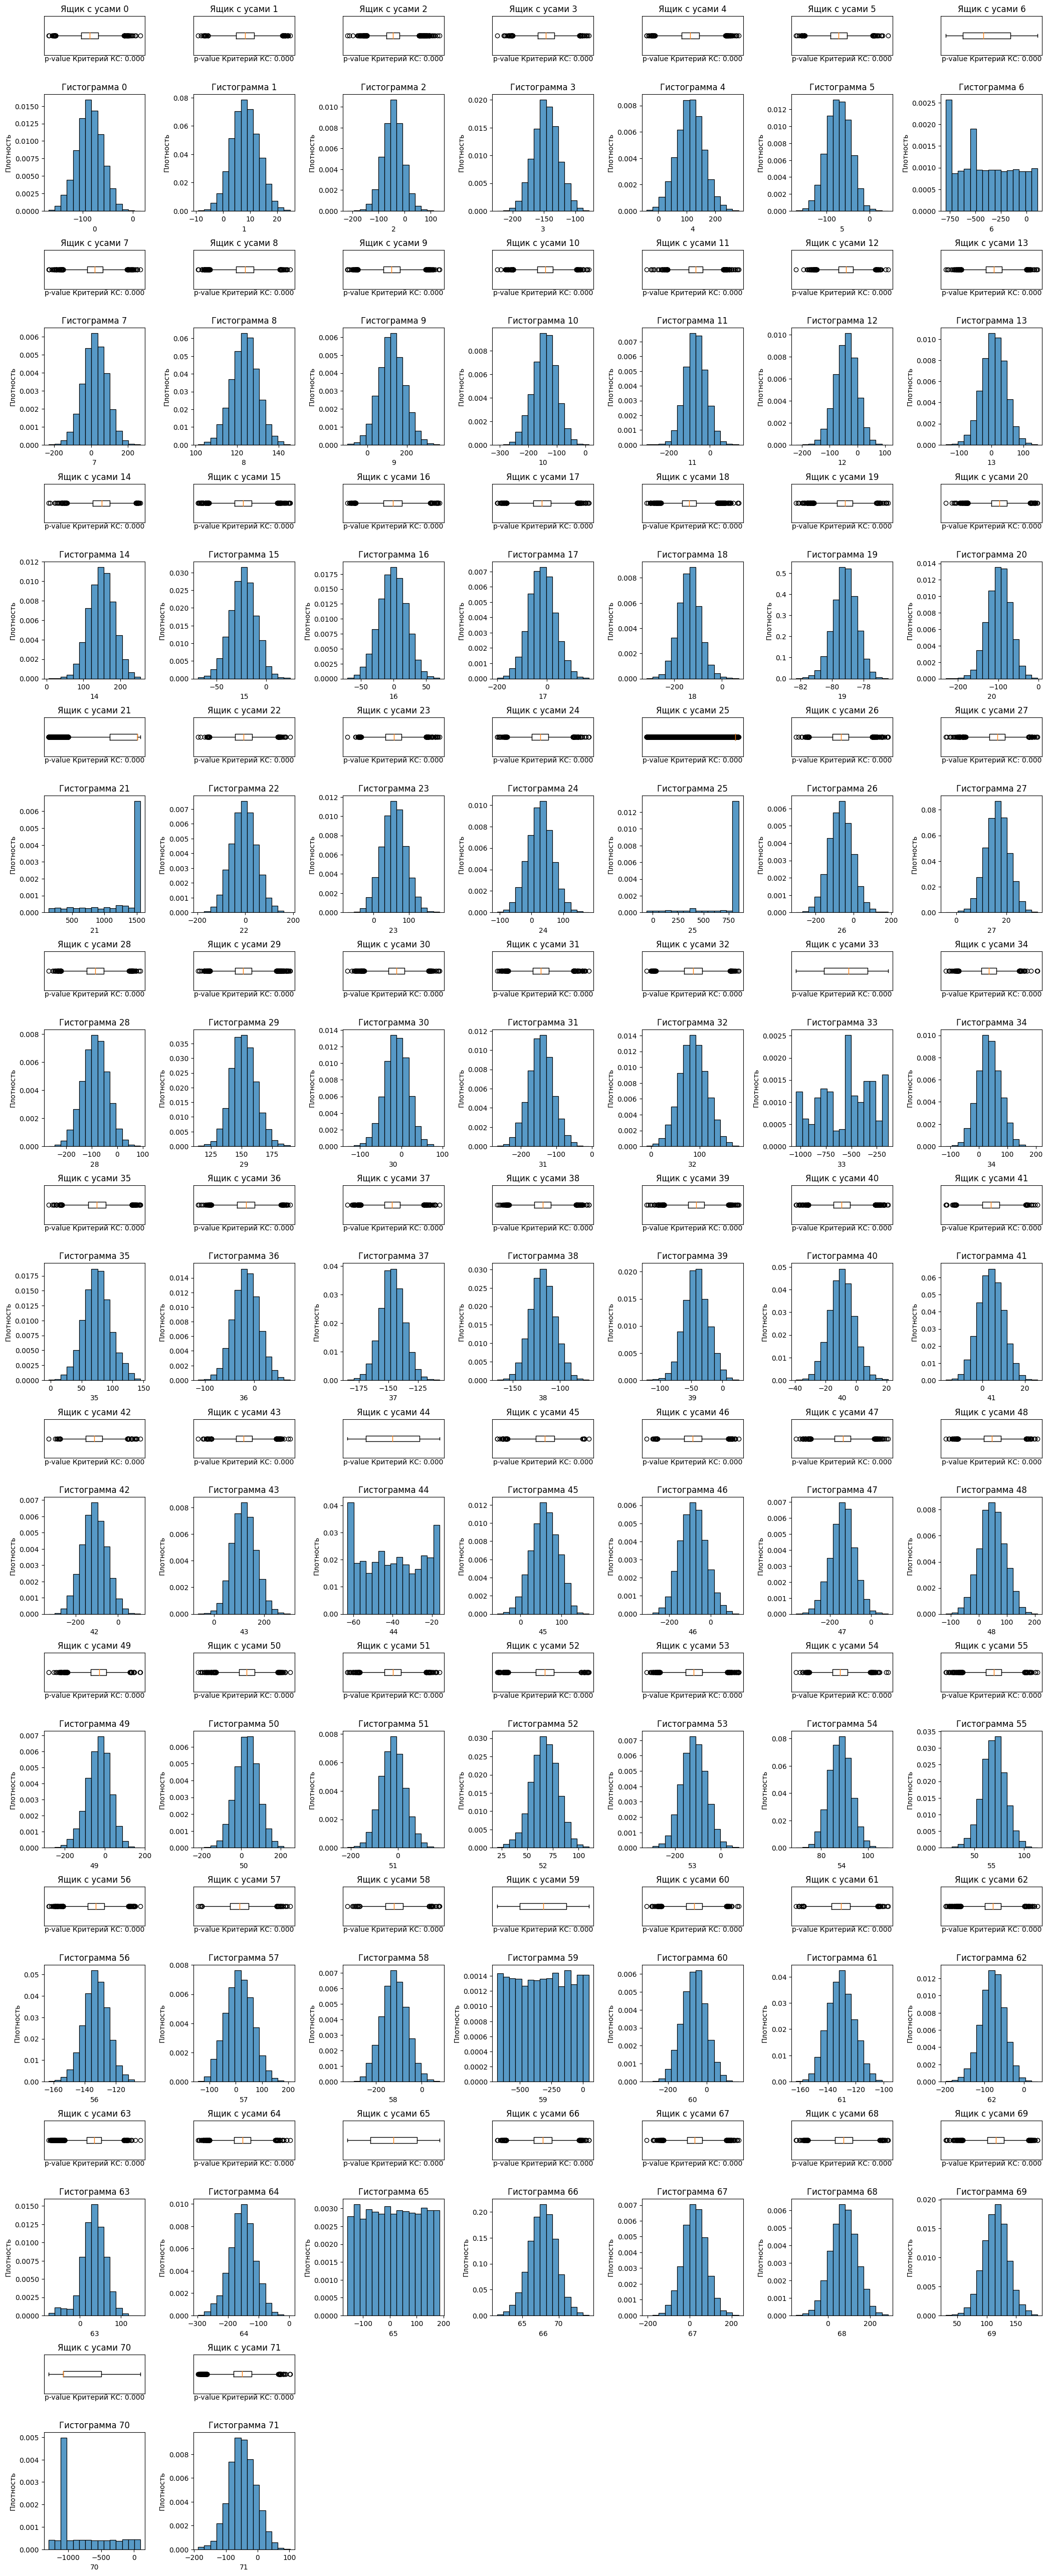

In [ ]:
visualizer = DataVisualizer(pandas_df=base, sample_size=10000)
visualizer.plot_quantitative()

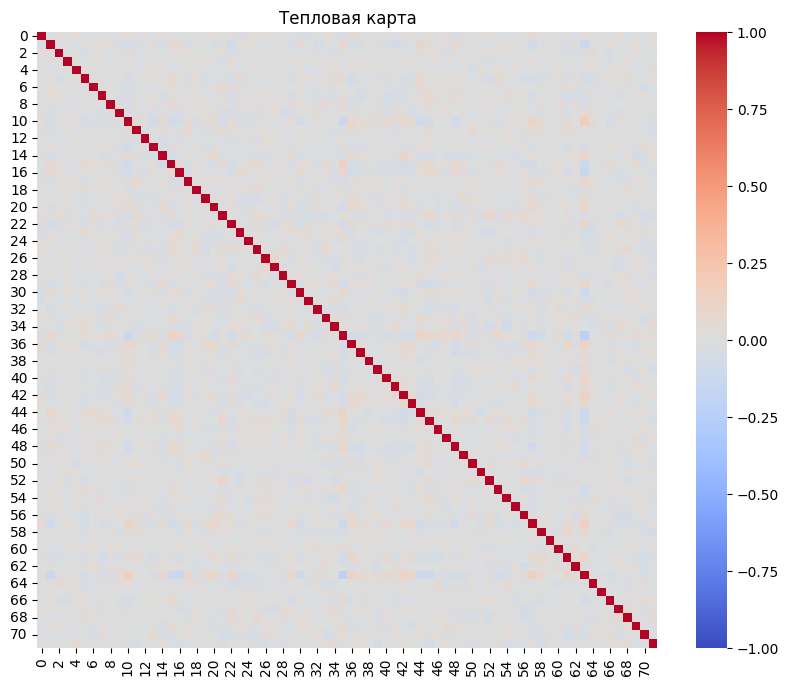

In [ ]:
visualizer.plot_correlation_heatmap()

**Вывод**

Вижу, что большинство признаков имеют схожее распределение с нормальным, (критерий Колмагорова-Смирнова показал, что все распредления не являются нормальными). Также замечу интересные признаки `6`,`21`, `25`, `33`, `44`, `59`, `65`, `70` они отличаются от большинства. Удалю их, можно конечно их попытаться привести к нормальному распредлению, но если на это будет время. Также отмечу, что распределения имеют разный масштаб, следовательно перед моделированием данные стоит масштабировать.

# Подготовка данных

In [ ]:
columns_drop = ['6','21', '25', '33', '44', '59', '65', '70']
base = base.drop(columns_drop, axis=1)
train = train.drop(columns_drop, axis=1)
validation = validation.drop(columns_drop, axis=1)

In [ ]:
def normalize_with_indices(df):

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_norm = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)

    return df_norm

In [ ]:
# Исключаем столбцы, которые не являются признаками
target = train['Target']
train = train.drop(columns=['Target'])

base = normalize_with_indices(base)
train  = normalize_with_indices(train)
validation = normalize_with_indices(validation)

**Вывод**

В этом шаге подготовила данные для поиска ближайших соседей при помощи библиотеки Faiss.

# Поиск ближайших соседей с Faiss

FAISS (Facebook AI Similarity Search) — это библиотека, предназначенная для быстрого поиска ближайших соседей (nearest neighbors) в больших наборах данных. Она особенно полезна при работе с высокоразмерными векторными представлениями, которые часто встречаются в задачах машинного обучения, таких как обработка изображений, текстов, рекомендационные системы и многое другое.

Ниже иницировала класс `FaissIndexer`. Он используется для создания, обучения и оценки FAISS индекса, который предназначен для быстрого поиска ближайших соседей в многомерных данных. Вот что делает каждый компонент класса:

1. Конструктор `__init__`:
- `base_scaled`: Принятый на вход масштабированный базовый набор данных. Он преобразуется в формат, пригодный для работы с FAISS.
- `n_cells`: Количество ячеек в FAISS индексе. Чем больше значение, тем более детализированно индекс разделяет пространство поиска.
- `nprobe`: Количество ячеек, которые будут проверены при поиске ближайших соседей. Чем больше значение, тем более точный, но медленный будет поиск.
- `dims`: Количество измерений в данных (например, число признаков).
quantizer: Объект FAISS, который используется для расчета расстояний между векторами.
- `idx_l2`: Сам индекс, который использует квантайзер для поиска ближайших соседей в многомерном пространстве.
- `base_scaled`: Массив базовых данных, подготовленных для работы с FAISS.
- `base_index`: Словарь, который связывает индексы объектов в базе с их оригинальными индексами в исходных данных.
2. Метод `train_and_add`:
Этот метод обучает индекс на базовом наборе данных (base) и добавляет его в индекс для последующего поиска.
3. Метод `search`:
- Выполняет поиск ближайших соседей для заданного набора данных (train) на основе ранее созданного индекса.
- `k_neighbours`: Число ближайших соседей, которые нужно найти.
Возвращает вектора расстояний и индексы найденных соседей.
4. Метод `calculate_accuracy`:
- Оценивает точность поиска на тренировочном наборе данных.
- Сравнивает правильные ответы (target) с найденными соседями (idx).
- Выводит метрику `accuracy@5`, которая показывает, сколько правильных ответов было среди пяти ближайших соседей для каждого объекта в наборе данных.
5. Метод `add_validation_data`:
- Добавляет валидационный набор данных и правильные ответы для него.
- Эти данные сохраняются в атрибутах класса для последующей оценки.
6. Метод `evaluate_validation`:
Выполняет поиск ближайших соседей для валидационного набора данных.
Сравнивает найденные соседей с правильными ответами, вычисляет и выводит метрику `accuracy@5` для валидационной выборки.

In [ ]:
class FaissIndexer:
    def __init__(self, base_scaled=None, n_cells=1000, nprobe=100):
        self.dims = base_scaled.shape[1] if base_scaled is not None else None
        self.n_cells = n_cells
        self.nprobe = nprobe
        self.idx_l2 = None
        self.base_scaled = None
        self.base_index = None

        if base_scaled is not None:
            self.base_scaled = np.ascontiguousarray(base_scaled).astype('float32')
            self.base_index = {k: v for k, v in enumerate(base_scaled.index.to_list())}
            self._initialize_index()

    def _initialize_index(self, index_type='flat'):
        if index_type == 'flat':
            self.idx_l2 = faiss.IndexFlatL2(self.dims)
        elif index_type == 'ivfflat':
            quantizer = faiss.IndexFlatL2(self.dims)
            self.idx_l2 = faiss.IndexIVFFlat(quantizer, self.dims, self.n_cells)
        elif index_type == 'ivfpq':
            quantizer = faiss.IndexFlatL2(self.dims)
            self.idx_l2 = faiss.IndexIVFPQ(quantizer, self.dims, self.n_cells, 8, 8)
        elif index_type == 'hnsw':
            self.idx_l2 = faiss.IndexHNSWFlat(self.dims, 32)
        elif index_type == 'lsh':
            self.idx_l2 = faiss.IndexLSH(self.dims, 128)
        self.idx_l2.nprobe = self.nprobe

    def train_and_add(self):
        self.idx_l2.train(self.base_scaled)
        self.idx_l2.add(self.base_scaled)

    def search(self, train_scaled, k_neighbours=30):
        train_scaled = np.ascontiguousarray(train_scaled.values).astype('float32')
        vecs, idx = self.idx_l2.search(train_scaled, k_neighbours)
        return vecs, idx

    def calculate_accuracy(self, target, idx):
        acc = 0
        for targets, el in zip(target.values.tolist(), idx.tolist()):
            acc += int(targets in [self.base_index[r] for r in el])
        accuracy = 100 * acc / len(idx)
        print(f'accuracy@5 для тренировачных данных {accuracy}')
        return accuracy

    def add_validation_data(self, validation, validation_answer):
        self.validation = np.ascontiguousarray(validation.values).astype('float32')
        self.validation_answer = validation_answer['Expected'].values.tolist()

    def evaluate_validation(self, k_neighbours=30):
        vecs_v, idx_v = self.idx_l2.search(self.validation, k_neighbours)
        acc_v = 0
        for v, el_v in zip(self.validation_answer, idx_v.tolist()):
            acc_v += int(v in [self.base_index[r_v] for r_v in el_v])
        accuracy = 100 * acc_v / len(idx_v)
        print(f'accuracy@5 для валидационных данных {accuracy}')
        return accuracy

    def optimize_with_optuna(self, train_scaled, target, validation, validation_answer, n_trials=50):
        def objective(trial):
            start_time = time.time()

            index_type = trial.suggest_categorical('index_type', ['flat', 'ivfflat', 'ivfpq', 'hnsw', 'lsh'])
            k_neighbours = trial.suggest_int('k_neighbours', 10, 50, step=10)

            self._initialize_index(index_type)
            self.train_and_add()

            # Оценка на тренировочных данных
            train_accuracy = self.calculate_accuracy(target, self.search(train_scaled, k_neighbours)[1])

            # Добавление данных для валидации и оценка
            self.add_validation_data(validation, validation_answer)
            validation_accuracy = self.evaluate_validation(k_neighbours)

            elapsed_time = time.time() - start_time
            print(f'Траил выполнен за {elapsed_time:.2f} секунд')

            return validation_accuracy

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)

        print("Лучшие параметры:")
        print("Тип индекса:", study.best_params['index_type'])
        print("Оптимальное k_neighbours:", study.best_params['k_neighbours'])
        print("Лучшая метрика accuracy@5 на валидационной выборке:", study.best_value)

        # Сохранение лучших параметров для дальнейшего использования
        self.selected_index_type = study.best_params['index_type']
        self.selected_k_neighbours = study.best_params['k_neighbours']

    def reinitialize_with_best_params(self):
        # Пересоздание индекса с лучшими параметрами
        self._initialize_index(self.selected_index_type)
        self.train_and_add()


In [ ]:
indexer = FaissIndexer(base)
indexer.train_and_add()
vecs, idx = indexer.search(train)
train_accuracy = indexer.calculate_accuracy(target, idx)

accuracy@5 для тренировачных данных 77.534


In [ ]:
indexer.add_validation_data(validation, validation_answer)
validation_accuracy = indexer.evaluate_validation()

accuracy@5 для валидационных данных 77.428


**Вывод**

Была обучена модель для поиска ближайшех соседей со следующими входными даными:
- масштабируемые датасеты (base, train, validation)
- параметры `n_cells`=1000 и `nprobe`=100

По итогу получились метрики `accuracy@5` на тренировочной 77.534 (расчет произведен приблизительно за 20 минут) и валидационной 76.788 (здесь рассчет произведен также около 20 минут).

Чем бы я еще дополнила:
1. Подбрала оптимальное количества соседей (`k_neighbours`): проверила, как изменяется точность при использовании различных значений `k_neighbours`(например, 5, 10, 20). Подбор оптимального значения может существенно повлиять на результат.
2. Настройка параметров FAISS. Здесь я бы варьировала параметры индексации, такие как `n_cells` и `nprobe`. Большее количество кластеров (n_cells) может улучшить точность, но замедлить поиск. Увеличение nprobe может также улучшить качество поиска, но за счет времени выполнения.
3. Использование других типов индексов. Например, такие как `IVFPQ` или `HNSW`. Они могут дать лучшие результаты на определенных типах данных.

UPD. На 2 итерации дополнила класс моими рассуждениями. Единственное оставила только `n_cells` и `nprobe` без каких либо изменений.

In [ ]:
# Запуск оптимизации
indexer.optimize_with_optuna(train, target, validation, validation_answer, n_trials=10)

[I 2024-08-13 09:08:42,077] A new study created in memory with name: no-name-951f6be6-c86f-4985-a127-794db16eeecd


accuracy@5 для тренировачных данных 78.329


[I 2024-08-13 09:58:21,119] Trial 0 finished with value: 78.267 and parameters: {'index_type': 'flat', 'k_neighbours': 40}. Best is trial 0 with value: 78.267.


accuracy@5 для валидационных данных 78.267
Траил выполнен за 2979.04 секунд
accuracy@5 для тренировачных данных 74.565


[I 2024-08-13 10:20:14,792] Trial 1 finished with value: 74.397 and parameters: {'index_type': 'lsh', 'k_neighbours': 40}. Best is trial 0 with value: 78.267.


accuracy@5 для валидационных данных 74.397
Траил выполнен за 1313.67 секунд
accuracy@5 для тренировачных данных 74.378


[I 2024-08-13 10:34:30,586] Trial 2 finished with value: 74.291 and parameters: {'index_type': 'ivfpq', 'k_neighbours': 30}. Best is trial 0 with value: 78.267.


accuracy@5 для валидационных данных 74.291
Траил выполнен за 855.79 секунд
accuracy@5 для тренировачных данных 73.625


[I 2024-08-13 10:56:19,843] Trial 3 finished with value: 73.478 and parameters: {'index_type': 'lsh', 'k_neighbours': 30}. Best is trial 0 with value: 78.267.


accuracy@5 для валидационных данных 73.478
Траил выполнен за 1309.25 секунд
accuracy@5 для тренировачных данных 69.763


[I 2024-08-13 11:18:06,023] Trial 4 finished with value: 69.532 and parameters: {'index_type': 'lsh', 'k_neighbours': 10}. Best is trial 0 with value: 78.267.


accuracy@5 для валидационных данных 69.532
Траил выполнен за 1306.17 секунд
accuracy@5 для тренировачных данных 73.533


[I 2024-08-13 11:44:26,578] Trial 5 finished with value: 73.471 and parameters: {'index_type': 'ivfflat', 'k_neighbours': 10}. Best is trial 0 with value: 78.267.


accuracy@5 для валидационных данных 73.471
Траил выполнен за 1580.55 секунд
accuracy@5 для тренировачных данных 73.939


[I 2024-08-13 12:35:21,299] Trial 6 finished with value: 73.885 and parameters: {'index_type': 'flat', 'k_neighbours': 10}. Best is trial 0 with value: 78.267.


accuracy@5 для валидационных данных 73.885
Траил выполнен за 3054.71 секунд
accuracy@5 для тренировачных данных 62.218


[I 2024-08-13 12:57:46,831] Trial 7 finished with value: 62.241 and parameters: {'index_type': 'hnsw', 'k_neighbours': 30}. Best is trial 0 with value: 78.267.


accuracy@5 для валидационных данных 62.241
Траил выполнен за 1345.53 секунд
accuracy@5 для тренировачных данных 76.913


[I 2024-08-13 13:24:01,144] Trial 8 finished with value: 76.788 and parameters: {'index_type': 'ivfflat', 'k_neighbours': 30}. Best is trial 0 with value: 78.267.


accuracy@5 для валидационных данных 76.788
Траил выполнен за 1574.31 секунд
accuracy@5 для тренировачных данных 74.378


[I 2024-08-13 13:38:20,332] Trial 9 finished with value: 74.291 and parameters: {'index_type': 'ivfpq', 'k_neighbours': 30}. Best is trial 0 with value: 78.267.


accuracy@5 для валидационных данных 74.291
Траил выполнен за 859.19 секунд
Лучшие параметры:
Тип индекса: flat
Оптимальное k_neighbours: 40
Лучшая метрика accuracy@5 на валидационной выборке: 78.267


Пока код грузится опишу, что за апдейт произошел в классе.
Начну с очевидного недостатка, скорее всего он будет считать очень долго. Здесь бы хорошо использовать процессор GPU для ускорения вычислений, но гугл не дает его применить из-за ограничений.

Итак, в класс добавила метод `evaluate_different_indexes`, который перебирает количество ближайших соседей и индексы. А на выходе результат метрик для тренировочной и валидационой данных с учетом индекса и количество ближайших соседей.

Если с количеством ближайших соседей все более-менее понятно: `k_neighbours_options = [10, 20, 30, 40, 50]` (отмечу, что это не самый элегантый способ, здесь можно было бы с помощью метода локтя посмотреть какие числа лучше), какие индексы были использованны.

1. `IndexFlatL2`. Это простой индекс, который использует вычисление расстояния L2 (евклидово расстояние) между векторами. Он подходит для небольших наборов данных, где не требуется оптимизация по скорости или памяти. Для наших данных не очень подходит, но энивей, попробуем.
2. `IndexIVFFlat`.  Этот индекс разбивает базу данных на кластеры и выполняет поиск только в нескольких ближайших кластерах, что значительно ускоряет процесс.Полезен для больших наборов данных, когда требуется быстрее находить ближайших соседей. Был первоначально использован, т.к. лучше всего подходил, исходя из наших входных данных.
3. `IndexIVFPQ`. Это комбинация кластеризации (IVF) и продукции квантизации (PQ), которая обеспечивает компромисс между скоростью и потреблением памяти.Рекомендуется для очень больших наборов данных, где нужно значительно сократить объем памяти, используемой индексом, при небольшом снижении точности. (Здесь я поняла, что нужно было еще также зафиксировать время, при последущей итерации, дорбавлю).
4. `IndexHNSW`. Индекс на основе графа малых миров (HNSW), который оптимизирован для быстрого поиска ближайших соседей.Предлагает отличный баланс между точностью и скоростью для высокоразмерных данных. Аналогичная ситуация, что и в предыдущем случае.
5. `IndexLSH`. Использует локально чувствительное хеширование для эффективного поиска ближайших соседей, особенно для данных высокой размерности. Подходит для наборов данных с высокой размерностью, когда требуется быстрая, но менее точная оценка. Хоть и признаков не так много, но все проинсектировать тоже хотелось бы.



In [ ]:
indexer.reinitialize_with_best_params()

In [ ]:
    def optimize_with_optuna(self, train_scaled, target, validation, validation_answer, n_trials=50):
        def objective(trial):
            start_time = time.time()

            index_type = trial.suggest_categorical('index_type', ['flat', 'ivfflat', 'ivfpq', 'hnsw', 'lsh'])
            k_neighbours = trial.suggest_int('k_neighbours', 10, 50, step=10)

            self._initialize_index(index_type)
            self.train_and_add()

            # Оценка на тренировочных данных
            train_accuracy = self.calculate_accuracy(target, self.search(train_scaled, k_neighbours)[1])

            # Добавление данных для валидации и оценка
            self.add_validation_data(validation, validation_answer)
            validation_accuracy = self.evaluate_validation(k_neighbours)

            elapsed_time = time.time() - start_time
            print(f'Траил выполнен за {elapsed_time:.2f} секунд')

            return validation_accuracy

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)

        print("Лучшие параметры:")
        print("Тип индекса:", study.best_params['index_type'])
        print("Оптимальное k_neighbours:", study.best_params['k_neighbours'])
        print("Лучшая метрика accuracy@5 на валидационной выборке:", study.best_value)

        # Сохранение лучших параметров для дальнейшего использования
        self.selected_index_type = study.best_params['index_type']
        self.selected_k_neighbours = study.best_params['k_neighbours']